# Logistic Regression Project: Cardiovascular Disease Risk Modelling

---
### Task
Analyse dataset, create a logistic regression model for predicting 10-year risk of coronary heart disease (CHD) and calculate the optimal threshold. 

### Dataset
Kaggle train dataset from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts:
https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea?select=train.csv

### Working Assumptions

For choosing which model fits best I will hold the following assumptions true:
1. The model will be used to recommend coronoary heart desease preventive measures rather than as a tool for diagnosis
2. All the measurements and medical history details are stored for each patient anyways and having less indicators in the model does not make any difference for a doctor's routine
3. Identifying patients more prone to chd is the most important, but not alerting too many patients is also important
4. No more than half of patients should receive the recommendations for chd risk preventive measures

To jump staight to conclusions, click [here](#conclusion).

---

### Notebook Structure
1. Data loading and cleaning
2. Exploratory data analysis
3. Modelling and Optimisation
4. Conclusions
5. Next steps

---
<br>

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
sns.set_style('darkgrid')
sns.set_palette('colorblind')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (6, 3)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

<br>

## Data Loading and Cleaning

In [7]:
df = pd.read_csv("./train.csv", index_col='id')
df.shape

(3390, 16)

There is no information on what education values represent. This makes education column not interpretable. I will drop it.

In [8]:
df = df.drop(columns=['education'])

Let's drop duplicates, if any.

In [9]:
df = df.drop_duplicates()
df.shape[0]

3390

Number of rows stayed the same, no duplicates found. Next, let's glimpse into the data.

I'll fix the case of column names to be consistent and more readable.

In [10]:
df.rename(columns={'cigsPerDay': 'cigs_per_day',
                   'BPMeds': 'bp_meds',
                   'prevalentStroke': 'prevalent_stroke',
                   'prevalentHyp': 'prevalent_hyp',
                   'diabetes': 'diabetes',
                   'totChol': 'cholesterol',
                   'sysBP': 'systolic_bp',
                   'diaBP': 'diastolic_bp',
                   'BMI': 'bmi',
                   'heartRate': 'heart_rate',
                   'glucose': 'glucose',
                   'TenYearCHD': 'ten_year_chd'},
          inplace=True)

In [11]:
df.head(10)

,age,sex,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd
id,,,,,,,,,,,,,,,
0,64,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0
5,61,F,NO,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1
6,61,M,NO,0.0,0.0,0,1,0,238.0,232.0,136.0,24.83,75.0,79.0,0
7,36,M,YES,35.0,0.0,0,0,0,295.0,102.0,68.0,28.15,60.0,63.0,0
8,41,F,YES,20.0,NaN,0,0,0,220.0,126.0,78.0,20.70,86.0,79.0,0


Noticed that bp_meds and bmi columns have NaN values. I'll check if other columns have NaN values and how many.

In [12]:
na_percentage = df.isna().mean() * 100
na_percentage_rounded = na_percentage.round(2)
na_percentage_rounded[na_percentage_rounded > 0]

cigs_per_day    0.65
bp_meds         1.30
cholesterol     1.12
bmi             0.41
heart_rate      0.03
glucose         8.97
dtype: float64

Target column - ten_year_chd - has no missing values, wonderful. Glucose has almost 9% of values missing. I suspect that glocose might be very useful for predicting heart disease, but I do not want to loose 9% of dataset by removing rows with NaNs. High glucose levels should mean that a person had diabetes. Diabetes column has no null values. I will look into correlation between the two.

In [13]:
df[['glucose', 'diabetes', 'ten_year_chd']].corr()

,glucose,diabetes,ten_year_chd
glucose,1.000000,0.620211,0.138200
diabetes,0.620211,1.000000,0.103681
ten_year_chd,0.138200,0.103681,1.000000


The correlation is there, but it is not high enoug to say that glucose level can be omitted and only diabetes used for modelling. I will now check if glucose level distribution is skewed.

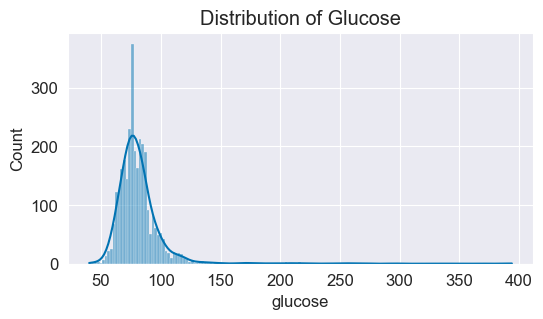

In [14]:
sns.histplot(df['glucose'].dropna(), kde=True)
plt.title('Distribution of Glucose');

Distribution is skewed, thus, I will use median for imputing NaN values and also create a column to know which values were imputed.

In [15]:
df['glucose_imputed'] = df['glucose'].isna()
median_glucose = df['glucose'].median()
df['glucose'].fillna(median_glucose, inplace=True)
df.head(10)

,age,sex,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd,glucose_imputed
id,,,,,,,,,,,,,,,,
0,64,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1,False
1,36,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,False
2,46,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,False
3,50,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,False
4,64,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,False
5,61,F,NO,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1,False
6,61,M,NO,0.0,0.0,0,1,0,238.0,232.0,136.0,24.83,75.0,79.0,0,False
7,36,M,YES,35.0,0.0,0,0,0,295.0,102.0,68.0,28.15,60.0,63.0,0,False
8,41,F,YES,20.0,NaN,0,0,0,220.0,126.0,78.0,20.70,86.0,79.0,0,False


I will now check what are the the observations with still missing values: the people with CHD or not.

In [16]:
results = []

features_with_na = ['cigs_per_day',
                    'bp_meds',
                    'cholesterol',
                    'bmi',
                    'heart_rate']

for feature in features_with_na:
    df_missing = df[df[feature].isna()]
    chd_counts = df_missing['ten_year_chd'].value_counts()
    results_dict = {'Feature': feature,
                    'CHD = 0': chd_counts.get(0, 0),
                    'CHD = 1': chd_counts.get(1, 0)}
    results.append(results_dict)

missing_values_summary = pd.DataFrame(results)

missing_values_summary

,Feature,CHD = 0,CHD = 1
0,cigs_per_day,21,1
1,bp_meds,37,7
2,cholesterol,31,7
3,bmi,7,7
4,heart_rate,0,1


In [17]:
df['ten_year_chd'].value_counts()

ten_year_chd
0    2879
1     511
Name: count, dtype: int64

If I drop all observations with missing values, I will loose 23 out of only 511 observations from people with chd (4.5% of positive labels). That is not good. I will better use imputation method not to loose any. I'll start with cigs_per_day.

In [18]:
df['is_smoking'].value_counts()

is_smoking
NO     1703
YES    1687
Name: count, dtype: int64

In [19]:
non_smokers = df[df['is_smoking'] == 'NO']
non_smokers['cigs_per_day'].isna().any()

False

Number of cigarettes per day is missing for a person who is smoking. I will check the distribution and stats for cigarettes per day for smokers only to decide which value to impute.

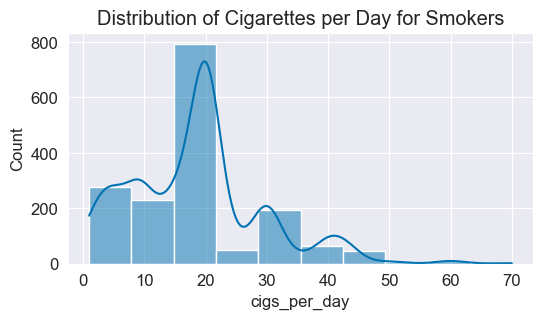

In [20]:
smokers = df[df['is_smoking'] == 'YES']
sns.histplot(smokers['cigs_per_day'].dropna(), bins=10, kde=True)
plt.title('Distribution of Cigarettes per Day for Smokers');

In [21]:
smokers['cigs_per_day'].describe()

count    1665.000000
mean       18.345946
std        10.735196
min         1.000000
25%        10.000000
50%        20.000000
75%        20.000000
max        70.000000
Name: cigs_per_day, dtype: float64

In [22]:
smokers['cigs_per_day'].mode()

0    20.0
Name: cigs_per_day, dtype: float64

Distribution is skewed. Mode and median are equal to 20, so I will impute with this value.

In [23]:
df['cigs_per_day_imputed'] = df['cigs_per_day'].isna()
median_cigs_per_day = df['cigs_per_day'].median()
df['cigs_per_day'].fillna(median_cigs_per_day, inplace=True)
df['cigs_per_day'].isna().any()

False

Next, bp_meds.

In [24]:
df['bp_meds'].value_counts()

bp_meds
0.0    3246
1.0     100
Name: count, dtype: int64

In [25]:
mode_bp_meds = df['bp_meds'].mode()[0]
mode_bp_meds

0.0

If a person was on blood pressure medicine has only 1 or 0 values. I will impute with the most frequent value - 0.

In [26]:
df['bp_meds_imputed'] = df['bp_meds'].isna()
df['bp_meds'].fillna(mode_bp_meds, inplace=True)
df['bp_meds'].isna().any()

False

Now it's turn for cholesterol.

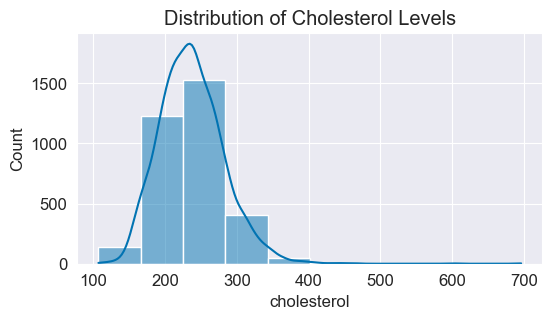

In [27]:
sns.histplot(df['cholesterol'].dropna(), bins=10, kde=True)
plt.title('Distribution of Cholesterol Levels');

In [28]:
df['cholesterol'].describe()

count    3352.000000
mean      237.074284
std        45.247430
min       107.000000
25%       206.000000
50%       234.000000
75%       264.000000
max       696.000000
Name: cholesterol, dtype: float64

In [29]:
df['cholesterol'].mode()

0    240.0
Name: cholesterol, dtype: float64

Distribution is skewed, median is 234 while the most frequent value is 240. Since there are a lot of different values for cholesterol level, I will use median for imputation.

In [30]:
df['cholesterol_imputed'] = df['cholesterol'].isna()
median_cholesterol = df['cholesterol'].median()
df['cholesterol'].fillna(median_cholesterol, inplace=True)
df['cholesterol'].isna().any()

False

Now I'll deal with missing values for bmi.

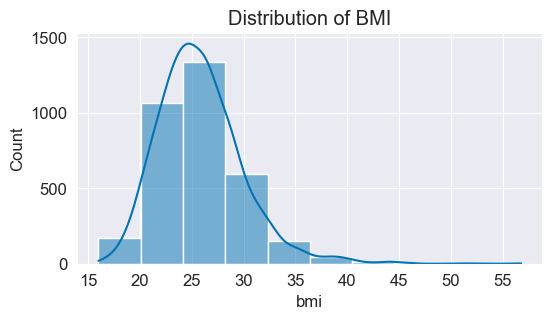

In [31]:
sns.histplot(df['bmi'].dropna(), bins=10, kde=True)
plt.title('Distribution of BMI');

In [32]:
df['bmi'].describe()

count    3376.000000
mean       25.794964
std         4.115449
min        15.960000
25%        23.020000
50%        25.380000
75%        28.040000
max        56.800000
Name: bmi, dtype: float64

In [33]:
df['bmi'].mode()

0    22.91
Name: bmi, dtype: float64

Same as with cholesterol level, distribution of bmi is skewed and it has a lot of different values. Median will work for imputation best.

In [34]:
df['bmi_imputed'] = df['bmi'].isna()
median_bmi = df['bmi'].median()
df['bmi'].fillna(median_bmi, inplace=True)
df['bmi'].isna().any()

False

Lastly, heart rate.

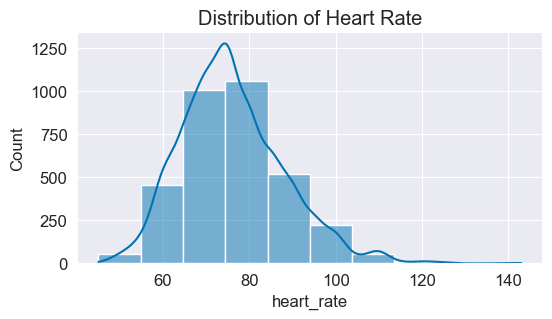

In [35]:
sns.histplot(df['heart_rate'].dropna(), bins=10, kde=True)
plt.title('Distribution of Heart Rate');

In [36]:
df['heart_rate'].describe()

count    3389.000000
mean       75.977279
std        11.971868
min        45.000000
25%        68.000000
50%        75.000000
75%        83.000000
max       143.000000
Name: heart_rate, dtype: float64

In [37]:
df['heart_rate'].mode()

0    75.0
Name: heart_rate, dtype: float64

Median and mode match. I will impute missing heart rate values with median.

In [38]:
df['heart_rate_imputed'] = df['heart_rate'].isna()
median_heart_rate = df['heart_rate'].median()
df['heart_rate'].fillna(median_heart_rate, inplace=True)
df.isna().any()

age                     False
sex                     False
is_smoking              False
cigs_per_day            False
bp_meds                 False
prevalent_stroke        False
prevalent_hyp           False
diabetes                False
cholesterol             False
systolic_bp             False
diastolic_bp            False
bmi                     False
heart_rate              False
glucose                 False
ten_year_chd            False
glucose_imputed         False
cigs_per_day_imputed    False
bp_meds_imputed         False
cholesterol_imputed     False
bmi_imputed             False
heart_rate_imputed      False
dtype: bool

No missing values left. Great!

I will now check if there are any issues with data in columns based on their data type.

In [39]:
df.dtypes

age                       int64
sex                      object
is_smoking               object
cigs_per_day            float64
bp_meds                 float64
prevalent_stroke          int64
prevalent_hyp             int64
diabetes                  int64
cholesterol             float64
systolic_bp             float64
diastolic_bp            float64
bmi                     float64
heart_rate              float64
glucose                 float64
ten_year_chd              int64
glucose_imputed            bool
cigs_per_day_imputed       bool
bp_meds_imputed            bool
cholesterol_imputed        bool
bmi_imputed                bool
heart_rate_imputed         bool
dtype: object

bp_meds is a binary column. Since no missing values left, I will convert it to int.

In [40]:
df['bp_meds'] = df['bp_meds'].astype('int64')

I will now look at categorical data: sex and is_smoking.

In [41]:
df['sex'].value_counts()

sex
F    1923
M    1467
Name: count, dtype: int64

In [42]:
df['is_smoking'].value_counts()

is_smoking
NO     1703
YES    1687
Name: count, dtype: int64

Sex and if a person is smoking have only valid values. Great! Both of them repesent only 1 of 2 values, which makes it very easy to convert them to binary which will be needed for modelling. This will be done in EDA.

In [43]:
non_smokers['cigs_per_day'].value_counts()

cigs_per_day
0.0    1703
Name: count, dtype: int64

The number of cigarettes per day for each non-smoker is 0. No issues.

Next, binary and numeric data.

In [44]:
df.describe().round(2)

,age,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd
count,3390.00,3390.00,3390.00,3390.00,3390.00,3390.00,3390.00,3390.00,3390.00,3390.00,3390.00,3390.00,3390.00
mean,49.54,9.01,0.03,0.01,0.32,0.03,237.04,132.60,82.88,25.79,75.98,81.72,0.15
std,8.59,11.86,0.17,0.08,0.46,0.16,44.99,22.29,12.02,4.11,11.97,23.16,0.36
min,32.00,0.00,0.00,0.00,0.00,0.00,107.00,83.50,48.00,15.96,45.00,40.00,0.00
25%,42.00,0.00,0.00,0.00,0.00,0.00,206.00,117.00,74.50,23.03,68.00,72.00,0.00
50%,49.00,0.00,0.00,0.00,0.00,0.00,234.00,128.50,82.00,25.38,75.00,78.00,0.00
75%,56.00,20.00,0.00,0.00,1.00,0.00,264.00,144.00,90.00,28.00,83.00,85.00,0.00
max,70.00,70.00,1.00,1.00,1.00,1.00,696.00,295.00,142.50,56.80,143.00,394.00,1.00


- Age is from 32 to 70. All valid values.
- Cigarettes per day has a very large value of 70. Will need to see if there is only one such huge value. Smoking 70 cigarettes per day should not be something common, but possible.
- Binary column values are all 0s and 1s, no issues with values.
- Cholesterol levels vary between 107 and 696. 696 mg/dL is a very high, but still possible value which indicates emergency situation.
- Systolic BP varies between 83.50 and 295. 83.50 seems valid, but 295, again, indicates an emergency condition.
-  Diastolic BP varies between 48 and 142.50. Same as cholesterol and systolic blood pressure max - 142.50 in diastolic blood pressure is an emergency situation.
-  BMI is between 15.96 and 56.80. BMI above 40 is considered severe obesity, but 56.80 is not an impossible value.
-  Heart rate is between 45 and 143. Heart rate is possible to be at 45 beats per minute when relaxed and it may rise to 143 when performing high physical activity. The dataset description does not say in which physical activity status the measurement was taken so I will assume that it is in regular state.
-  Glucose level is between 40 and 394 in the dataset. Both, min and max values indicate emergency health conditions.

Maybe the highest values belong to the same person?

In [45]:
df[
   (df['cigs_per_day'] == 70) | 
   (df['cholesterol'] == 696) |
   (df['systolic_bp'] == 295) |
   (df['diastolic_bp'] == 142.50) |
   (df['bmi'] == 56.80) |
   (df['glucose'] == 394)
]

,age,sex,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd,glucose_imputed,cigs_per_day_imputed,bp_meds_imputed,cholesterol_imputed,bmi_imputed,heart_rate_imputed
id,,,,,,,,,,,,,,,,,,,,,
512,51,M,YES,9.0,0,0,1,0,696.0,157.0,87.0,24.44,95.0,84.0,0,False,False,False,False,False,False
1032,67,F,NO,0.0,1,0,1,1,303.0,204.0,96.0,27.86,75.0,394.0,1,False,False,False,False,False,False
1200,55,F,NO,0.0,0,0,1,0,208.0,190.0,130.0,56.80,90.0,86.0,1,False,False,False,False,False,False
1587,62,M,NO,0.0,0,0,0,1,346.0,102.5,66.5,17.17,80.0,394.0,1,False,False,False,False,False,False
1941,64,F,NO,0.0,0,0,1,0,253.0,295.0,135.0,38.82,92.0,70.0,1,False,False,False,False,False,False
2325,48,F,NO,0.0,0,0,1,0,169.0,243.0,142.5,28.49,85.0,77.0,0,False,False,False,False,False,False
2985,40,M,YES,70.0,0,0,1,0,210.0,132.0,86.0,31.57,98.0,80.0,0,False,False,False,False,False,False


No, each extreme max value belongs to a different person. And there are 2 people with max glucose value. No rows that would be necessary to remove at this point.

<br>

This leaves me with the following after data cleaning step:
- Dataset with 3390 rows with no missing values
- All 511 positive labels preserved by imputing missing values
- 14 features to possibly add to the model of predicting ten_year_chd:
  - 2 categorical: sex and is_smoking (to be converted to binary)
  - 4 binary: bp_meds, prevalent_stroke, prevalent_hyp and diabetes
  - 8 numeric: age, cigs_per_day, cholesterol, systolic_bp, diastolic_bp, bmi, heart_rate and glucose

<br>

## Exploratory Data Analysis

I will look at the distribution of 10 year risk of coronary heart disease.

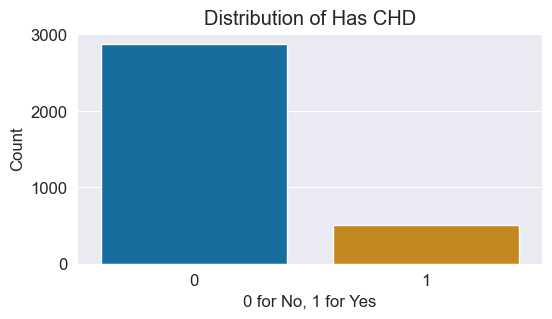

In [46]:
sns.countplot(x='ten_year_chd', hue='ten_year_chd', data=df, legend=False)

plt.xlabel('0 for No, 1 for Yes')
plt.ylabel('Count')
plt.title('Distribution of Has CHD');

Distribution of values is not even: 6 times less people have coronary heart disease than not. Classes are imbalanced. This means that accuracy is not going to be the best metric to optimise for when modelling.

I will now explore how well the dataset represents population demographically.

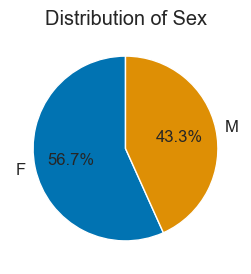

In [47]:
sex_counts = df['sex'].value_counts()
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sex');

By [online resources](https://www.citypopulation.de/en/usa/massachusetts/middlesex/2524960__framingham/), Framingham, Massachusets population is 49% male and 51% female. In our dataset females are represented more. To account for the difference, weighting technique could be used in modelling.

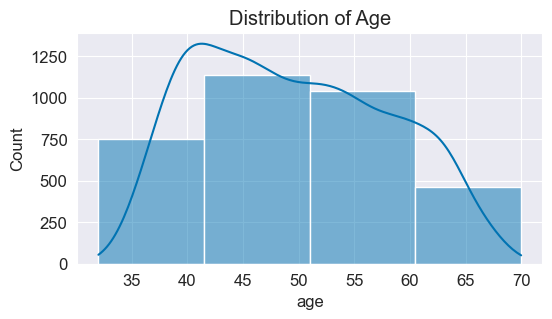

In [48]:
sns.histplot(df.age, bins=4, kde=True)
plt.title('Distribution of Age');

Again, by [online resourses](https://www.citypopulation.de/en/usa/massachusetts/middlesex/2524960__framingham/) teh biggest difference of the dataset vs actual population is the 60-70 age group. This age group is underepresented in the dataset. Min age in the dataset is 32 which means that all younger ages are omitted. I will assume it is very unlikely to have CHD at young age and that is why younger group not being represented is not creating a problem with modelling.

I'll look into the distribution of binary features.

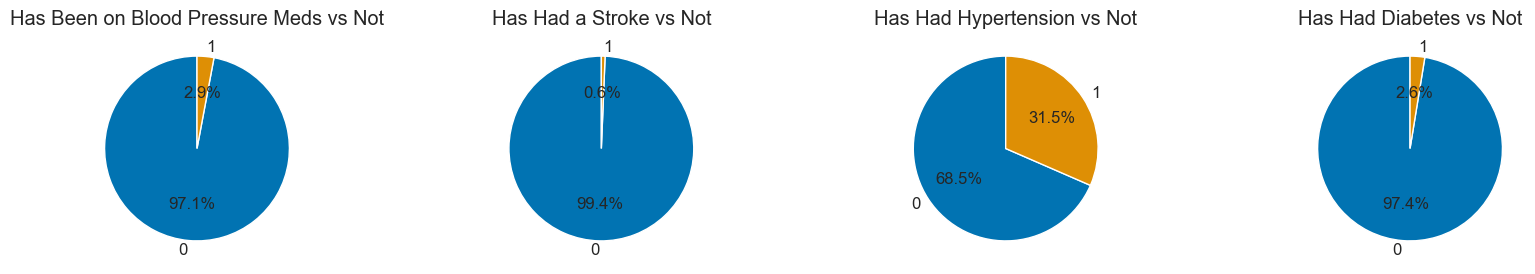

In [49]:
binary_features = ['bp_meds',
                   'prevalent_stroke',
                   'prevalent_hyp',
                   'diabetes']

titles = ['Has Been on Blood Pressure Meds vs Not',
          'Has Had a Stroke vs Not',
          'Has Had Hypertension vs Not',
          'Has Had Diabetes vs Not']

fig, axs = plt.subplots(1, 4, figsize=(20, 3))

for i, var in enumerate(binary_features):
    counts = df[var].value_counts()
    axs[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(titles[i])

In [50]:
df['prevalent_stroke'].value_counts()

prevalent_stroke
0    3368
1      22
Name: count, dtype: int64

Only 22 out of 3390 cases had a stroke. Prevalent stroke feature will need to be interpreted cautiously.

Now I'll explore the distribution of the rest of numeric features.

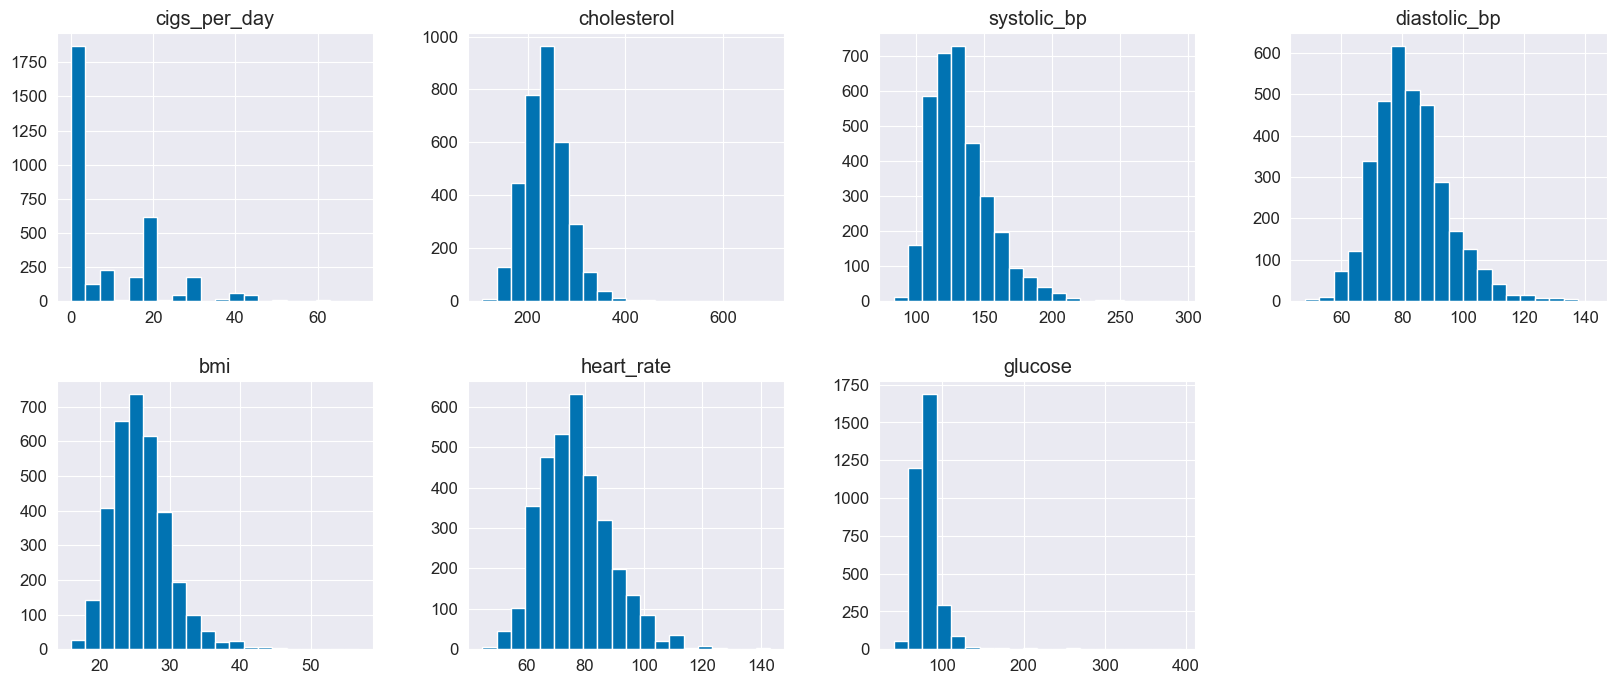

In [51]:
numeric_features = ['cigs_per_day',
                    'cholesterol',
                    'systolic_bp',
                    'diastolic_bp',
                    'bmi',
                    'heart_rate',
                    'glucose']

df[numeric_features].hist(bins=20, figsize=(20, 8), layout=(2, 4));

All of them seem to have some level of skewness. I will apply log transformation.

In [52]:
for feature in numeric_features:
    df[f'{feature}_log'] = np.log(df[feature] + 1)

df.head()

,age,sex,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd,glucose_imputed,cigs_per_day_imputed,bp_meds_imputed,cholesterol_imputed,bmi_imputed,heart_rate_imputed,cigs_per_day_log,cholesterol_log,systolic_bp_log,diastolic_bp_log,bmi_log,heart_rate_log,glucose_log
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,64,F,YES,3.0,0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1,False,False,False,False,True,False,1.386294,5.402677,5.003946,4.454347,3.272606,4.510860,4.394449
1,36,M,NO,0.0,0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,False,False,False,False,False,False,0.000000,5.361292,5.129899,4.595120,3.426540,4.290459,4.330733
2,46,F,YES,10.0,0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,False,False,False,False,False,False,2.397895,5.525453,4.762174,4.276666,3.061052,4.488636,4.553877
3,50,M,YES,20.0,0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,False,False,False,False,False,False,3.044522,5.455321,5.068904,4.488636,3.376221,4.234107,4.553877
4,64,F,YES,30.0,0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,False,False,False,False,False,False,3.433987,5.488938,4.923624,4.454347,3.311273,4.262680,4.356709


Before jumping to correlations, I'll transform categorical features to binary.

In [53]:
df['smoker'] = df['is_smoking'].map({'YES': 1, 'NO': 0})
df['female'] = df['sex'].map({'F': 1, 'M': 0})

df.head()

,age,sex,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd,glucose_imputed,cigs_per_day_imputed,bp_meds_imputed,cholesterol_imputed,bmi_imputed,heart_rate_imputed,cigs_per_day_log,cholesterol_log,systolic_bp_log,diastolic_bp_log,bmi_log,heart_rate_log,glucose_log,smoker,female
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,64,F,YES,3.0,0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1,False,False,False,False,True,False,1.386294,5.402677,5.003946,4.454347,3.272606,4.510860,4.394449,1,1
1,36,M,NO,0.0,0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,False,False,False,False,False,False,0.000000,5.361292,5.129899,4.595120,3.426540,4.290459,4.330733,0,0
2,46,F,YES,10.0,0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,False,False,False,False,False,False,2.397895,5.525453,4.762174,4.276666,3.061052,4.488636,4.553877,1,1
3,50,M,YES,20.0,0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,False,False,False,False,False,False,3.044522,5.455321,5.068904,4.488636,3.376221,4.234107,4.553877,1,0
4,64,F,YES,30.0,0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,False,False,False,False,False,False,3.433987,5.488938,4.923624,4.454347,3.311273,4.262680,4.356709,1,1


Let's see if the features correlate with each other.

In [54]:
columns_for_corr = ['age',
                    'smoker',
                    'female',
                    'bp_meds',
                    'prevalent_stroke',
                    'prevalent_hyp',
                    'diabetes',
                    'cigs_per_day_log',
                    'cholesterol_log',
                    'systolic_bp_log',
                    'diastolic_bp_log',
                    'bmi_log', 'heart_rate_log',
                    'glucose_log']

correlation_matrix = df[columns_for_corr].corr()
correlation_matrix

,age,smoker,female,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,cigs_per_day_log,cholesterol_log,systolic_bp_log,diastolic_bp_log,bmi_log,heart_rate_log,glucose_log
age,1.000000,-0.210997,0.041882,0.122114,0.059038,0.308826,0.107875,-0.218908,0.284280,0.407648,0.219533,0.140739,-0.005544,0.119407
smoker,-0.210997,1.000000,-0.215485,-0.037533,-0.043703,-0.119325,-0.053333,0.928582,-0.049684,-0.147897,-0.127495,-0.176870,0.067216,-0.071017
female,0.041882,-0.215485,1.000000,0.043191,0.011273,-0.003072,-0.008853,-0.283014,0.066274,0.025402,-0.065580,-0.108665,0.123335,0.011263
bp_meds,0.122114,-0.037533,0.043191,1.000000,0.116183,0.256892,0.070932,-0.037548,0.079456,0.246766,0.189996,0.084309,0.009519,0.041168
prevalent_stroke,0.059038,-0.043703,0.011273,0.116183,1.000000,0.071652,0.010115,-0.042954,-0.014145,0.057905,0.045614,0.010152,-0.020184,0.022441
prevalent_hyp,0.308826,-0.119325,-0.003072,0.256892,0.071652,1.000000,0.082565,-0.110166,0.157490,0.701137,0.601181,0.296012,0.147008,0.088531
diabetes,0.107875,-0.053333,-0.008853,0.070932,0.010115,0.082565,1.000000,-0.049597,0.052035,0.116012,0.058965,0.081498,0.039977,0.513701
cigs_per_day_log,-0.218908,0.928582,-0.283014,-0.037548,-0.042954,-0.110166,-0.049597,1.000000,-0.042030,-0.139456,-0.111538,-0.158377,0.075541,-0.084962
cholesterol_log,0.284280,-0.049684,0.066274,0.079456,-0.014145,0.157490,0.052035,-0.042030,1.000000,0.208850,0.166235,0.133102,0.086247,0.055031
systolic_bp_log,0.407648,-0.147897,0.025402,0.246766,0.057905,0.701137,0.116012,-0.139456,0.208850,1.000000,0.777700,0.334960,0.172823,0.134253


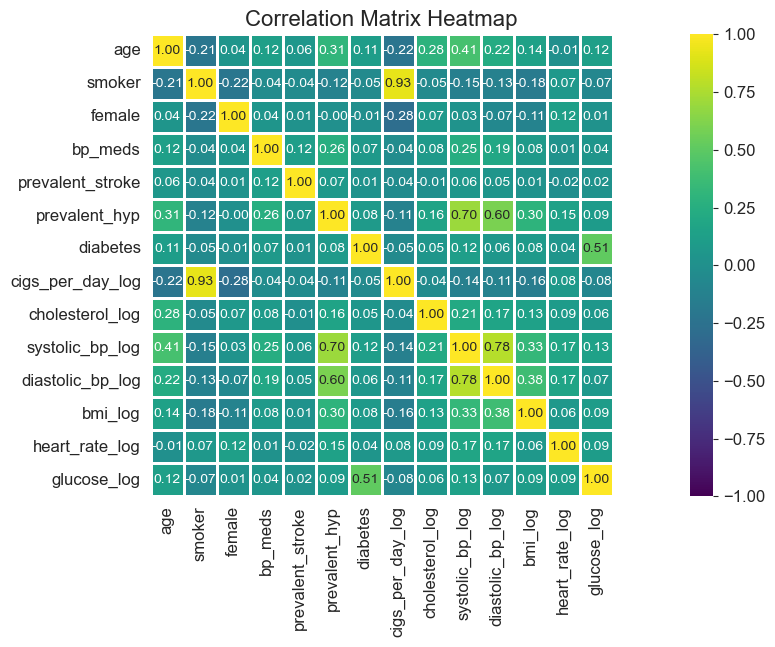

In [55]:
plt.figure(figsize=(20, 6))

fig = sns.heatmap(correlation_matrix,
                  annot=True,
                  cmap='viridis',
                  fmt='.2f',
                  vmin=-1,
                  vmax=1,
                  linewidths=.9,
                  square=True,
                  annot_kws={"size": 10})

plt.title('Correlation Matrix Heatmap', fontsize=16);

As expected, positive correlation inspected between the following features:
- smoker and cigs_per_day_log
- prevalent_hyp, systolic_bp_log and diastolic_bp_log
- diabetes and glucose_log

All could be as good predictors for CHD. Let's look into correlation of all features to the dependent variable. Maybe it will suggest which one of each group of correlated variables should be taken into modelling.

In [72]:
df[columns_for_corr].apply(lambda x: df['ten_year_chd'].corr(x))

age                 0.224927
smoker              0.034143
female             -0.084647
bp_meds             0.087349
prevalent_stroke    0.068627
prevalent_hyp       0.166544
diabetes            0.103681
cigs_per_day_log    0.053577
cholesterol_log     0.090013
systolic_bp_log     0.207119
diastolic_bp_log    0.127976
bmi_log             0.062289
heart_rate_log      0.020136
glucose_log         0.116196
dtype: float64

I will check for multicolinearity.

In [56]:
df_vif = pd.DataFrame(df, columns=columns_for_corr)
vif_data = pd.DataFrame()
vif_data['Feature'] = df_vif.columns
vif_data['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
print(vif_data)

             Feature          VIF
0                age    46.202603
1             smoker    14.807450
2             female     2.764040
3            bp_meds     1.130143
4   prevalent_stroke     1.026394
5      prevalent_hyp     2.222031
6           diabetes     1.333999
7   cigs_per_day_log    14.429723
8    cholesterol_log   837.585412
9    systolic_bp_log  3188.833026
10  diastolic_bp_log  2713.709681
11           bmi_log   590.444414
12    heart_rate_log   799.338115
13       glucose_log   618.881246


Correlation with target variable is low with each of the features. However, several features has very hight multicolinearity. I will keep all of them and apply Elastic Net regularization to deal with multicolinearity when modelling.

<br>

This concludes EDA phase. 

What has been done:
- continuous features converted to natural logarithms
- categorical features transformed to binary

What can be recommended for modelling stage:
- apply weight on female to account for different distribution by sex in population vs dataset
- use Elastic Net regularization to account for multicolinearity

<br>

## Modelling and Optimisation

First, I will form a DataFrame with only the columns needed.

In [57]:
X = df[['age',
        'smoker',
        'female',
        'bp_meds',
        'prevalent_stroke',
        'prevalent_hyp',
        'diabetes',
        'cigs_per_day_log',
        'cholesterol_log',
        'systolic_bp_log',
        'diastolic_bp_log',
        'bmi_log',
        'heart_rate_log',
        'glucose_log']]

y = df['ten_year_chd']

I will set test data aside from training data with startification to have balanced count of positive samples in both, training and testing parts of the dataset.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (2712, 14)
Testing set size: (678, 14)


Now I will use standard scaler to scale all numeric features.

In [59]:
numeric_features = ['age',
                    'cigs_per_day_log',
                    'cholesterol_log',
                    'systolic_bp_log',
                    'diastolic_bp_log',
                    'bmi_log',
                    'heart_rate_log',
                    'glucose_log']

binary_features = ['smoker',
                   'female',
                   'bp_meds',
                   'prevalent_stroke',
                   'prevalent_hyp',
                   'diabetes']

X_train_numeric = X_train[numeric_features]
X_train_binary = X_train[binary_features]
X_test_numeric = X_test[numeric_features]
X_test_binary = X_test[binary_features]

scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)

X_train_numeric_scaled_df = pd.DataFrame(X_train_numeric_scaled,
                                         columns=numeric_features,
                                         index=X_train.index)

X_test_numeric_scaled_df = pd.DataFrame(X_test_numeric_scaled,
                                        columns=numeric_features,
                                        index=X_test.index)

X_train_transformed = pd.concat([X_train_numeric_scaled_df,
                                 X_train_binary],
                                axis=1)

X_test_transformed = pd.concat([X_test_numeric_scaled_df,
                                X_test_binary],
                               axis=1)

In [60]:
X_train_transformed.head()

,age,cigs_per_day_log,cholesterol_log,systolic_bp_log,diastolic_bp_log,bmi_log,heart_rate_log,glucose_log,smoker,female,bp_meds,prevalent_stroke,prevalent_hyp,diabetes
id,,,,,,,,,,,,,,
406,-1.128033,-0.922608,-0.342492,-1.697002,-2.197479,-1.633701,-0.278663,-1.410783,0,1,0,0,0,0
461,-1.244292,1.153039,-0.669333,-1.542544,-1.638905,-1.627242,0.402536,0.302895,1,1,0,0,0,0
1288,-0.546741,1.609173,0.932405,0.182531,0.154896,-0.449034,-0.014843,-0.057932,1,0,0,0,0,0
1702,-0.546741,-0.922608,-0.318156,-1.215472,-0.099870,0.044263,-0.014843,-0.653383,0,1,0,0,0,0
1279,-1.244292,1.153039,-0.516006,-1.244516,-1.375298,0.470803,0.945503,-0.184249,1,0,0,0,0,0


In [61]:
model = LogisticRegression(solver='saga',
                           penalty='elasticnet',
                           class_weight='balanced',
                           max_iter=10000)

param_grid = {'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train_transformed, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best parameters found:  {'C': 0.01, 'l1_ratio': 0}
Best cross-validation score:  0.3741751936890228


l1_ratio 0 means that only Ridge regularization applied, because of multicolinearity. Now I will use the model with best parameters to predict values on test dataset.

In [62]:
y_train_probs = best_model.predict_proba(X_train_transformed)[:, 1]
y_test_probs = best_model.predict_proba(X_test_transformed)[:, 1]

I will now find the threshold that gives the optimal balance between recall and precision.

Optimal threshold: 0.53


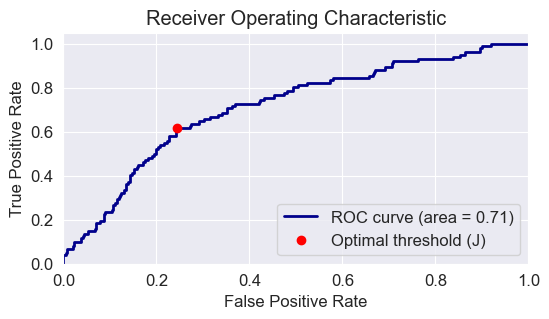

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx].round(2)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal threshold (J)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right');

print(f'Optimal threshold: {optimal_threshold}')

In [64]:
y_pred_threshold = (y_test_probs >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       576
           1       0.31      0.61      0.41       102

    accuracy                           0.73       678
   macro avg       0.61      0.68      0.62       678
weighted avg       0.82      0.73      0.77       678



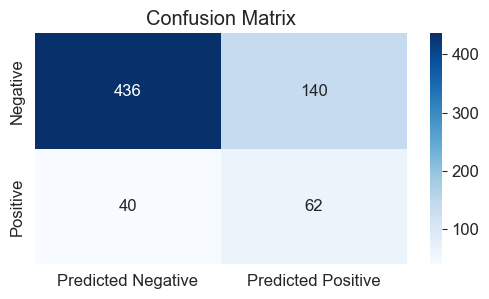

In [105]:
confusion_matrix = confusion_matrix(y_test, y_pred_threshold)

conf_matrix_df = pd.DataFrame(confusion_matrix,
                               index=['Negative', 'Positive'],
                               columns=['Predicted Negative', 'Predicted Positive'])

sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
        
plt.title('Confusion Matrix');

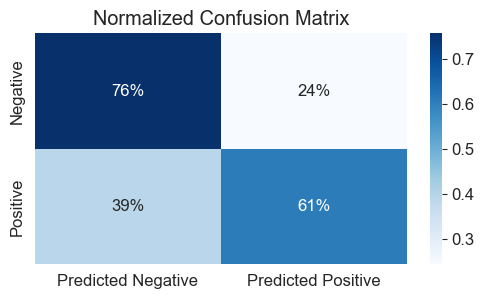

In [86]:
confusion_matrix = confusion_matrix(y_test, y_pred_threshold)

confusion_normalized = confusion_matrix.astype(float) / confusion_matrix.sum(axis=1)[:, np.newaxis]

conf_matrix_normalized_df = pd.DataFrame(confusion_normalized,
                                         index=['Negative', 'Positive'],
                                         columns=['Predicted Negative', 'Predicted Positive'])

sns.heatmap(conf_matrix_normalized_df, annot=True, fmt='.0%', cmap='Blues')
        
plt.title('Normalized Confusion Matrix');

The model predicts 61% of positives correctly. Also 69% of alerts to adjust lifestyle because of coronary heart disease will be false. But getting a healthier diet or more than none excercise cannot do any unwell, can it?

 This concludes modelling and optimisation. I will now look into coefficients and how they can be interpreted.

#### Interpretation

In [87]:
features = X.columns
coefficients = best_model.coef_[0]
intercept = best_model.intercept_[0]

df_coefficients = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
df_coefficients['Odds Ratio'] = np.exp(df_coefficients['Coefficient'])

df_intercept = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [intercept]})
df_intercept['Odds Ratio'] = np.exp(df_intercept['Coefficient'])

df_combined = pd.concat([df_coefficients, df_intercept], ignore_index=True)
df_combined = df_combined.sort_values(by='Odds Ratio', ascending=False)

df_combined

,Feature,Coefficient,Odds Ratio
0,age,0.429310,1.536197
3,bp_meds,0.294741,1.342778
1,smoker,0.262421,1.300074
12,heart_rate_log,0.148365,1.159936
7,cigs_per_day_log,0.130232,1.139092
2,female,0.101270,1.106576
13,glucose_log,0.093791,1.098330
4,prevalent_stroke,0.073469,1.076236
8,cholesterol_log,0.057871,1.059578
11,bmi_log,0.038655,1.039412


The odds ratio of intercept tells that all numeric features being at their mean and binary at 0, the odds ratio to have coronary heart disease decreases by ~15%.

The feature having the most impact on the probability to get CHD is older age. Increase of age by 1 standard deviation increases the odds to have coronary heart disease by ~54%.

The feature which lowers the risk of CHD is systolic_bp_log. 1 standard devuation away from the mean decreses the odds to have CHD by ~23%.

Out of binary features, being on blood pressure meds increases the odds to have CHD the most, while having diabetes - the least. But it is worth noting that the impact of diabetes is very small.

<a id="conclusion"></a>

---
---

## Conclusions

Overall data quality was not bad:
- no duplicates
- quite an amount of missing values (glucose was missing the most (9% of values), missing values imputed)
- column names adjusted for consistency and readability
- education column removed due to lack of information of how values should be interpreted

Several transformations were applied to prepare for modelling:
- categorical variables sex and is_smoker transformed to binary female and smoker, data type changed to int for bp_meds since it is binary
- log transformation applied for most of numeric features because of skewness
- strong multicolineariry detected for several features

The goal of modelling was to predict ten year coronary heart disease risk in order to give recommendations to edit lifestyle alerting no more than half the patients. Thus, optimizing for balance between recall and precision.

The following was done to get closer to the goal:
- dataset divided to train and test data 80/20
- Class weights for training data applied to account for 6 times less people in the dataset having CHD
- Elastic net regularisation applied to account for possible multicolinearity and remove unnecessary features
- best parameters for regularization found by applying iterations over parameter grid and cross validation
- Optimal threshold to balance recall and precision applied

The final best model was able to identify 61% of positive chd cases. Although precision is quite low at 31%, the goal to not alert more than half the patients is achieved.

---
---

## Next Steps

Since the under ROC curve area was 0.71 for the best model, it indicates that there is room for improvement.

- Fit Decision tree model
- Log transform age to account for missing values on the younger and very old age groups
- Try different library (e.g. statsmodels.api) for modelling
- Omit insignificant features based on their p-values and z-values and repeat modelling
- Omit features based on multicolinearity and repeat modelling
- Explore observations for which the model predicts poorly to detect possible improvements

For model to better perform in the real world, weights could be applied to reflect male/female distribution of poplulation more accurately.